In [74]:
%load_ext autoreload
%autoreload 2

import os
import sys
import logging

module_path = os.path.abspath(os.path.join("../../.."))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from pathlib import Path

import torch
import torch.utils.data
from torchvision import transforms, datasets
import numpy as np
import matplotlib.pyplot as plt

import pvi
from pvi.models import ClassificationBNNLocalRepam
from pvi.clients import Client
from pvi.servers import SequentialServer
from pvi.distributions import MeanFieldGaussianDistribution, MeanFieldGaussianFactor
from pvi.utils.training_utils import EarlyStopping

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
data_dir = Path("/Users/terjemildner/Desktop/data")
cache_dir = Path("/Users/terjemildner/Desktop/PVI-main/experiments/femnist")

## Define various functions for splitting data and recording performance metrics.

In [60]:
# Data splitting functions.
def homogeneous_split(data, num_clients=100, seed=42):
    # Set numpy's random seed.
    np.random.seed(seed)
    
    perm = np.random.permutation(len(data["x"]))
    client_data = []
    for i in range(num_clients):
        client_idx = perm[i::num_clients]
        print(client_idx)
        client_data.append({"x": data["x"][client_idx], "y": data["y"][client_idx]})
    
    return client_data

def het_split(data, seed=42):
    listed = np.argsort(data["y"])

    sorted_x = data["x"][listed[::1]]
    sorted_y = data["y"][listed[::1]]
    
    indexes =[]
    initial=-1
    for i in range(len(sorted_y)):
        if initial != sorted_y[i]:
            initial = sorted_y[i]
            indexes.append(i)
    indexes.append(len(sorted_y)) 
    client_data = []
    for i in range(len(indexes)-1):
        client_data.append({"x": sorted_x[indexes[i]:indexes[i+1]], "y": sorted_y[indexes[i]:indexes[i+1]]})
    
    return client_data
    
def heterogeneous_split(data, num_clients=100, seed=42):
    # Set numpy's random seed.
    listed = np.argsort(data["y"])

    sorted_x = data["x"][listed[::1]]
    sorted_y = data["y"][listed[::1]]
    
    l = len(data["y"])
    client_size = int(np.ceil(l/(2*num_clients)))
    
    data_parts_x = []
    data_parts_y = []
    
    for i in range(2*num_clients):
        data_parts_x.append(sorted_x[i*client_size:(i+1)*client_size]) 
        data_parts_y.append(sorted_y[i*client_size:(i+1)*client_size])
        
    rng = np.random.default_rng(seed)
    perm = rng.permutation((2*num_clients))
    
    client_data = []
    
    for i in range(num_clients):
        nums = perm[i::num_clients]
        x_data = torch.cat((data_parts_x[nums[0]], data_parts_x[nums[1]]))
        y_data = torch.cat((data_parts_y[nums[0]], data_parts_y[nums[1]]))
        client_data.append({"x": x_data, "y": y_data})
        
    return client_data

#Each shard contains only one class, classes are ordered together
def heterogeneous_split_2(data, num_clients=100):
    # Set numpy's random seed.
    listed = np.argsort(data["y"])

    sorted_x = data["x"][listed[::1]]
    sorted_y = data["y"][listed[::1]]
    
    l = len(data["y"])
    client_size = int(np.ceil(l/num_clients))
    print(client_size)
    client_data = []
    
    for i in range(num_clients):        
        client_data.append({"x": sorted_x[i*client_size:(i+1)*client_size], 
                            "y": sorted_y[i*client_size:(i+1)*client_size]})
    
    return client_data

#Each shard contains only one class, classes are randomly permutated
def heterogeneous_split_3(data, num_clients=100, seed=42):
    # Set numpy's random seed.
    listed = np.argsort(data["y"])

    sorted_x = data["x"][listed[::1]]
    sorted_y = data["y"][listed[::1]]
    
    l = len(data["y"])
    client_size = int(np.ceil(l/num_clients))
    
    data_parts_x = []
    data_parts_y = []
    
    for i in range(num_clients):
        data_parts_x.append(sorted_x[i*client_size:(i+1)*client_size]) 
        data_parts_y.append(sorted_y[i*client_size:(i+1)*client_size])
    
    rng = np.random.default_rng(seed)
    perm = rng.permutation(num_clients)
    
    client_data = []
    for i in range(num_clients):        
        client_idx = perm[i]
        client_data.append({"x": data_parts_x[client_idx], "y": data_parts_y[client_idx]})
    
    return client_data

# Performance metric function.
def performance_metrics(client, data, batch_size=512):
    dataset = torch.utils.data.TensorDataset(data["x"], data["y"])
    loader = torch.utils.data.DataLoader(dataset, batch_size=512, shuffle=False)
    
    device = client.config["device"]
    
    if device == "cuda":
        loader.pin_memory = True
        
    preds, mlls = [], []
    for (x_batch, y_batch) in loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        
        pp = client.model_predict(x_batch)
        preds.append(pp.component_distribution.probs.mean(1).cpu())
        mlls.append(pp.log_prob(y_batch).cpu())
        
    mll = torch.cat(mlls).mean()
    preds = torch.cat(preds)
    acc = sum(torch.argmax(preds, dim=-1) == loader.dataset.tensors[1]) / len(
        loader.dataset.tensors[1]
    )
    
    return {"mll": mll, "acc": acc}

## Data preprocessing

In [4]:
transform_train = transforms.Compose([transforms.ToTensor()])
transform_test = transforms.Compose([transforms.ToTensor()])

train_set = datasets.MNIST(root=data_dir, train=True, download=True, transform=transform_train)
test_set = datasets.MNIST(root=data_dir, train=False, download=True, transform=transform_test)

train_data = {
    "x": ((train_set.data - 0) / 255).reshape(-1, 28 * 28),
    "y": train_set.targets,
}

test_data = {
    "x": ((test_set.data - 0) / 255).reshape(-1, 28 * 28),
    "y": test_set.targets,
}

In [32]:
len(train_data["y"])

60000

In [38]:
# Get client splits.
client_data = heterogeneous_split_2(train_data, 10)
print(len(client_data))

6000
10


In [64]:
client_data = het_split(train_data)
test_classes = het_split(test_data)

In [54]:
client_data = het_split(train_data, 10)
print(len(client_data))
zeros=0
ones=0
twos=0
threes=0
fours=0
fives=0
sixs=0
sevens=0
eights=0
nines=0
for label in client_data:
    if label==0:
        zeros+=1
    elif label==1:
        ones+=1
    elif label==2:
        twos+=1
    elif label==3:
        threes+=1
    elif label==4:
        fours+=1
    elif label==5:
        fives+=1
    elif label==6:
        sixs+=1
    elif label==7:
        sevens+=1
    elif label==8:
        eights+=1
    elif label==9:
        nines+=1
    else:
        print(label)
print(f"zeros: {zeros}")
print(f"ones: {ones}")
print(f"twos: {twos}")
print(f"threes: {threes}")
print(f"fours: {fours}")
print(f"fives: {fives}")
print(f"sixs: {sixs}")
print(f"sevens: {sevens}")
print(f"eights: {eights}")
print(f"nines: {nines}")
print(f"sum: {zeros+ones+twos+threes+fours+fives+sixs+sevens+eights+nines}")

60000
zeros: 5923
ones: 6742
twos: 5958
threes: 6131
fours: 5842
fives: 5421
sixs: 5918
sevens: 6265
eights: 5851
nines: 5949
sum: 60000


## Define configuration for server and clients

In [67]:
model_config = {
    "input_dim": 784,
    "latent_dim": 200,
    "output_dim": 10,
    "num_layers": 1,
    "num_predictive_samples": 100,
    "prior_var": 1.0,
}

client_config = {
    "damping_factor": 1.0,
    "optimiser": "Adam",
    "optimiser_params": {"lr": 2e-3},
    "sigma_optimiser_params": {"lr": 2e-3},
    "early_stopping": EarlyStopping(50, score_name="elbo", stash_model=True),
    "performance_metrics": performance_metrics,
    "batch_size": 256,
    "epochs": 2500,
    "print_epochs": np.inf,
    "num_elbo_samples": 10,
    "valid_factors": False,
    "device": "cpu",
    "init_var": 1e-3,
    "verbose": True,
}

server_config = {
    **client_config,
    #100
    "max_iterations": 5,
}

## Set up model etc.

In [68]:
device = server_config["device"]

model = ClassificationBNNLocalRepam(config=model_config)

# Initial parameters.
init_q_std_params = {
    "loc": torch.zeros(size=(model.num_parameters,)).to(device).uniform_(-0.1, 0.1),
    "scale": torch.ones(size=(model.num_parameters,)).to(device) 
    * client_config["init_var"] ** 0.5,
}

prior_std_params = {
    "loc": torch.zeros(size=(model.num_parameters,)).to(device),
    "scale": model_config["prior_var"] ** 0.5 
    * torch.ones(size=(model.num_parameters,)).to(device),
}

init_factor_nat_params = {
    "np1": torch.zeros(model.num_parameters).to(device),
    "np2": torch.zeros(model.num_parameters).to(device),
}

p = MeanFieldGaussianDistribution(
    std_params=prior_std_params, is_trainable=False
)
init_q = MeanFieldGaussianDistribution(
    std_params=init_q_std_params, is_trainable=False
)

clients = []
size_training = 0
for i in range(10):
    data_i = client_data[i]
    val_i=test_classes[i]
    size_training += len(data_i["x"])
    t_i = MeanFieldGaussianFactor(nat_params=init_factor_nat_params)
    clients.append(
        Client(
            data=data_i,
            model=model,
            t=t_i,
            config=client_config,
            val_data=val_i
        )
    )    
server_0 = SequentialServer(model=model, p=p, clients=clients, config=server_config, init_q=init_q, data=train_data, val_data=test_classes[0])

## Run PVI! Test validation data only label '0'

In [70]:
i = 0
while not server_0.should_stop():
    server_0.tick()

    # Obtain performance metrics.
    metrics = server_0.log["performance_metrics"][-1]
    print("Iterations: {}.".format(i))
    print("Time taken: {:.3f}.".format(metrics["time"]))
    print(
      "Test mll: {:.3f}. Test acc: {:.3f}.".format(
          metrics["val_mll"], metrics["val_acc"]
      )
    )
    print(
      "Train mll: {:.3f}. Train acc: {:.3f}.\n".format(
          metrics["train_mll"], metrics["train_acc"]
      )
    )
    i += 1

0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 0.
Time taken: 4051.444.
Test mll: -545.770. Test acc: 0.000.
Train mll: -305.799. Train acc: 0.099.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

KeyboardInterrupt: 

## Run PVI! Test validation data only label '9'

In [71]:
model_config = {
    "input_dim": 784,
    "latent_dim": 200,
    "output_dim": 10,
    "num_layers": 1,
    "num_predictive_samples": 100,
    "prior_var": 1.0,
}

client_config = {
    "damping_factor": 1.0,
    "optimiser": "Adam",
    "optimiser_params": {"lr": 2e-3},
    "sigma_optimiser_params": {"lr": 2e-3},
    "early_stopping": EarlyStopping(50, score_name="elbo", stash_model=True),
    "performance_metrics": performance_metrics,
    "batch_size": 256,
    "epochs": 2500,
    "print_epochs": np.inf,
    "num_elbo_samples": 10,
    "valid_factors": False,
    "device": "cpu",
    "init_var": 1e-3,
    "verbose": True,
}

server_config = {
    **client_config,
    #100
    "max_iterations": 5,
}

In [72]:
device = server_config["device"]

model = ClassificationBNNLocalRepam(config=model_config)

# Initial parameters.
init_q_std_params = {
    "loc": torch.zeros(size=(model.num_parameters,)).to(device).uniform_(-0.1, 0.1),
    "scale": torch.ones(size=(model.num_parameters,)).to(device) 
    * client_config["init_var"] ** 0.5,
}

prior_std_params = {
    "loc": torch.zeros(size=(model.num_parameters,)).to(device),
    "scale": model_config["prior_var"] ** 0.5 
    * torch.ones(size=(model.num_parameters,)).to(device),
}

init_factor_nat_params = {
    "np1": torch.zeros(model.num_parameters).to(device),
    "np2": torch.zeros(model.num_parameters).to(device),
}

p = MeanFieldGaussianDistribution(
    std_params=prior_std_params, is_trainable=False
)
init_q = MeanFieldGaussianDistribution(
    std_params=init_q_std_params, is_trainable=False
)

clients = []
size_training = 0
for i in range(10):
    data_i = client_data[i]
    val_i=test_classes[i]
    size_training += len(data_i["x"])
    t_i = MeanFieldGaussianFactor(nat_params=init_factor_nat_params)
    clients.append(
        Client(
            data=data_i,
            model=model,
            t=t_i,
            config=client_config,
            val_data=val_i
        )
    )    
server_1 = SequentialServer(model=model, p=p, clients=clients, config=server_config, init_q=init_q, data=train_data, val_data=test_classes[9])

In [73]:
i = 0
while not server_1.should_stop():
    server_1.tick()

    # Obtain performance metrics.
    metrics1 = server_1.log["performance_metrics"][-1]
    print("Iterations: {}.".format(i))
    print("Time taken: {:.3f}.".format(metrics1["time"]))
    print(
      "Test mll: {:.3f}. Test acc: {:.3f}.".format(
          metrics1["val_mll"], metrics1["val_acc"]
      )
    )
    print(
      "Train mll: {:.3f}. Train acc: {:.3f}.\n".format(
          metrics1["train_mll"], metrics1["train_acc"]
      )
    )
    i += 1

0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 0.
Time taken: 4681.792.
Test mll: -0.000. Test acc: 1.000.
Train mll: -288.542. Train acc: 0.099.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 1.
Time taken: 11036.334.
Test mll: 0.000. Test acc: 1.000.
Train mll: -518.000. Train acc: 0.099.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

KeyboardInterrupt: 

# Heterogeneous Split with 1 class per client, clients arranged randomly

In [79]:
data3 = het_split(train_data, 10)

In [80]:
model_config = {
    "input_dim": 784,
    "latent_dim": 200,
    "output_dim": 10,
    "num_layers": 1,
    "num_predictive_samples": 100,
    "prior_var": 1.0,
}

client_config = {
    "damping_factor": 1.0,
    "optimiser": "Adam",
    "optimiser_params": {"lr": 2e-3},
    "sigma_optimiser_params": {"lr": 2e-3},
    "early_stopping": EarlyStopping(5, score_name="elbo", stash_model=True),
    "performance_metrics": performance_metrics,
    "batch_size": 256,
    "epochs": 20,
    "print_epochs": np.inf,
    "num_elbo_samples": 10,
    "valid_factors": False,
    "device": "cpu",
    "init_var": 1e-3,
    "verbose": True,
}

server_config = {
    **client_config,
    #100
    "max_iterations": 100,
}

In [81]:
device3 = server_config["device"]

model3 = ClassificationBNNLocalRepam(config=model_config)

# Initial parameters.
init_q_std_params = {
    "loc": torch.zeros(size=(model3.num_parameters,)).to(device3).uniform_(-0.1, 0.1),
    "scale": torch.ones(size=(model3.num_parameters,)).to(device3) 
    * client_config["init_var"] ** 0.5,
}

prior_std_params = {
    "loc": torch.zeros(size=(model3.num_parameters,)).to(device3),
    "scale": model_config["prior_var"] ** 0.5 
    * torch.ones(size=(model3.num_parameters,)).to(device3),
}

init_factor_nat_params = {
    "np1": torch.zeros(model3.num_parameters).to(device3),
    "np2": torch.zeros(model3.num_parameters).to(device3),
}

p = MeanFieldGaussianDistribution(
    std_params=prior_std_params, is_trainable=False
)
init_q = MeanFieldGaussianDistribution(
    std_params=init_q_std_params, is_trainable=False
)

clients3 = []
size_training = 0
for i in range(10):
    data_i = data3[i]
    size_training += len(data_i["x"])
    t_i = MeanFieldGaussianFactor(nat_params=init_factor_nat_params)
    clients3.append(
        Client(
            data=data_i,
            model=model3,
            t=t_i,
            config=client_config,
            val_data=test_data
        )
    )    
server3 = SequentialServer(model=model3, p=p, clients=clients3, config=server_config, init_q=init_q, data=train_data, val_data=test_data)

In [82]:
i = 0
while not server3.should_stop():
    server3.tick()

    # Obtain performance metrics.
    metrics3 = server3.log["performance_metrics"][-1]
    print("Iterations: {}.".format(i))
    print("Time taken: {:.3f}.".format(metrics3["time"]))
    print(
      "Test mll: {:.3f}. Test acc: {:.3f}.".format(
          metrics3["val_mll"], metrics3["val_acc"]
      )
    )
    print(
      "Train mll: {:.3f}. Train acc: {:.3f}.\n".format(
          metrics3["train_mll"], metrics3["train_acc"]
      )
    )
    i += 1

0it [00:00, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Iterations: 0.
Time taken: 325.645.
Test mll: -8.789. Test acc: 0.101.
Train mll: -8.630. Train acc: 0.099.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Iterations: 1.
Time taken: 420.952.
Test mll: -37.836. Test acc: 0.149.
Train mll: -37.245. Train acc: 0.148.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Iterations: 2.
Time taken: 516.648.
Test mll: -43.292. Test acc: 0.109.
Train mll: -44.420. Train acc: 0.107.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Iterations: 3.
Time taken: 611.637.
Test mll: -28.258. Test acc: 0.126.
Train mll: -27.262. Train acc: 0.128.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Iterations: 4.
Time taken: 706.937.
Test mll: -38.851. Test acc: 0.124.
Train mll: -38.721. Train acc: 0.127.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Iterations: 5.
Time taken: 802.446.
Test mll: -39.962. Test acc: 0.110.
Train mll: -40.068. Train acc: 0.111.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Iterations: 6.
Time taken: 897.236.
Test mll: -38.472. Test acc: 0.118.
Train mll: -38.417. Train acc: 0.118.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Iterations: 7.
Time taken: 991.187.
Test mll: -55.326. Test acc: 0.109.
Train mll: -54.929. Train acc: 0.108.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Iterations: 8.
Time taken: 1085.993.
Test mll: -54.822. Test acc: 0.103.
Train mll: -52.773. Train acc: 0.101.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Iterations: 9.
Time taken: 1181.557.
Test mll: -67.893. Test acc: 0.102.
Train mll: -64.165. Train acc: 0.100.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Iterations: 10.
Time taken: 1279.428.
Test mll: -52.003. Test acc: 0.110.
Train mll: -48.334. Train acc: 0.110.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Iterations: 11.
Time taken: 1374.027.
Test mll: -49.881. Test acc: 0.105.
Train mll: -48.301. Train acc: 0.103.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Iterations: 12.
Time taken: 1467.572.
Test mll: -64.053. Test acc: 0.103.
Train mll: -62.177. Train acc: 0.101.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Iterations: 13.
Time taken: 1562.457.
Test mll: -69.278. Test acc: 0.104.
Train mll: -66.991. Train acc: 0.102.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Iterations: 14.
Time taken: 1657.446.
Test mll: -56.719. Test acc: 0.112.
Train mll: -53.331. Train acc: 0.112.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Iterations: 15.
Time taken: 1751.442.
Test mll: -54.757. Test acc: 0.104.
Train mll: -53.324. Train acc: 0.102.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Iterations: 16.
Time taken: 1845.581.
Test mll: -52.809. Test acc: 0.117.
Train mll: -50.417. Train acc: 0.119.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Iterations: 17.
Time taken: 1938.490.
Test mll: -48.074. Test acc: 0.110.
Train mll: -48.299. Train acc: 0.110.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Iterations: 18.
Time taken: 2032.742.
Test mll: -66.942. Test acc: 0.108.
Train mll: -63.831. Train acc: 0.108.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Iterations: 19.
Time taken: 2128.448.
Test mll: -47.501. Test acc: 0.109.
Train mll: -46.940. Train acc: 0.108.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Iterations: 20.
Time taken: 2223.236.
Test mll: -45.709. Test acc: 0.128.
Train mll: -44.890. Train acc: 0.133.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Iterations: 21.
Time taken: 2317.990.
Test mll: -46.102. Test acc: 0.143.
Train mll: -47.392. Train acc: 0.150.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Iterations: 22.
Time taken: 2414.080.
Test mll: -50.916. Test acc: 0.109.
Train mll: -50.574. Train acc: 0.109.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Iterations: 23.
Time taken: 2507.910.
Test mll: -42.163. Test acc: 0.121.
Train mll: -40.852. Train acc: 0.125.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Iterations: 24.
Time taken: 2600.014.
Test mll: -41.341. Test acc: 0.154.
Train mll: -39.229. Train acc: 0.164.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Iterations: 25.
Time taken: 2692.451.
Test mll: -41.823. Test acc: 0.122.
Train mll: -41.629. Train acc: 0.125.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Iterations: 26.
Time taken: 2786.093.
Test mll: -35.292. Test acc: 0.160.
Train mll: -34.830. Train acc: 0.167.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Iterations: 27.
Time taken: 2879.604.
Test mll: -34.673. Test acc: 0.160.
Train mll: -33.627. Train acc: 0.168.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Iterations: 28.
Time taken: 2973.585.
Test mll: -37.621. Test acc: 0.172.
Train mll: -36.264. Train acc: 0.186.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Iterations: 29.
Time taken: 3065.620.
Test mll: -34.224. Test acc: 0.134.
Train mll: -32.247. Train acc: 0.143.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Iterations: 30.
Time taken: 3161.492.
Test mll: -26.832. Test acc: 0.159.
Train mll: -25.189. Train acc: 0.170.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Iterations: 31.
Time taken: 3256.498.
Test mll: -37.854. Test acc: 0.150.
Train mll: -35.210. Train acc: 0.161.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Iterations: 32.
Time taken: 3349.709.
Test mll: -28.391. Test acc: 0.128.
Train mll: -27.651. Train acc: 0.136.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Iterations: 33.
Time taken: 3442.658.
Test mll: -30.388. Test acc: 0.152.
Train mll: -30.535. Train acc: 0.161.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Iterations: 34.
Time taken: 3537.939.
Test mll: -27.320. Test acc: 0.167.
Train mll: -27.708. Train acc: 0.177.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Iterations: 35.
Time taken: 3631.188.
Test mll: -25.837. Test acc: 0.130.
Train mll: -26.091. Train acc: 0.132.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Iterations: 36.
Time taken: 3724.626.
Test mll: -29.375. Test acc: 0.166.
Train mll: -28.417. Train acc: 0.179.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Iterations: 37.
Time taken: 3819.045.
Test mll: -27.964. Test acc: 0.169.
Train mll: -26.958. Train acc: 0.182.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Iterations: 38.
Time taken: 3914.493.
Test mll: -25.093. Test acc: 0.146.
Train mll: -24.936. Train acc: 0.153.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Iterations: 39.
Time taken: 4005.915.
Test mll: -23.156. Test acc: 0.195.
Train mll: -21.687. Train acc: 0.205.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Iterations: 40.
Time taken: 4099.719.
Test mll: -19.901. Test acc: 0.164.
Train mll: -19.234. Train acc: 0.177.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Iterations: 41.
Time taken: 4194.031.
Test mll: -40.437. Test acc: 0.120.
Train mll: -38.486. Train acc: 0.124.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Iterations: 42.
Time taken: 4287.695.
Test mll: -28.140. Test acc: 0.157.
Train mll: -28.908. Train acc: 0.166.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Iterations: 43.
Time taken: 4379.455.
Test mll: -21.711. Test acc: 0.143.
Train mll: -21.094. Train acc: 0.151.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Iterations: 44.
Time taken: 4473.709.
Test mll: -30.072. Test acc: 0.153.
Train mll: -29.615. Train acc: 0.164.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Iterations: 45.
Time taken: 4568.238.
Test mll: -22.868. Test acc: 0.150.
Train mll: -22.883. Train acc: 0.157.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Iterations: 46.
Time taken: 4661.120.
Test mll: -21.798. Test acc: 0.134.
Train mll: -21.316. Train acc: 0.144.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Iterations: 47.
Time taken: 4753.349.
Test mll: -34.465. Test acc: 0.119.
Train mll: -33.569. Train acc: 0.124.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Iterations: 48.
Time taken: 4847.241.
Test mll: -22.086. Test acc: 0.137.
Train mll: -21.182. Train acc: 0.145.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Iterations: 49.
Time taken: 4940.465.
Test mll: -25.161. Test acc: 0.142.
Train mll: -24.732. Train acc: 0.150.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Iterations: 50.
Time taken: 5034.927.
Test mll: -17.314. Test acc: 0.140.
Train mll: -17.669. Train acc: 0.149.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Iterations: 51.
Time taken: 5130.517.
Test mll: -21.821. Test acc: 0.125.
Train mll: -21.242. Train acc: 0.128.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Iterations: 52.
Time taken: 5225.595.
Test mll: -21.562. Test acc: 0.132.
Train mll: -20.843. Train acc: 0.140.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Iterations: 53.
Time taken: 5320.415.
Test mll: -25.962. Test acc: 0.130.
Train mll: -24.909. Train acc: 0.134.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Iterations: 54.
Time taken: 5416.701.
Test mll: -18.506. Test acc: 0.141.
Train mll: -17.890. Train acc: 0.147.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Iterations: 55.
Time taken: 5512.123.
Test mll: -18.790. Test acc: 0.135.
Train mll: -17.444. Train acc: 0.142.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Iterations: 56.
Time taken: 5607.943.
Test mll: -23.739. Test acc: 0.136.
Train mll: -23.230. Train acc: 0.141.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Iterations: 57.
Time taken: 5704.348.
Test mll: -14.152. Test acc: 0.141.
Train mll: -13.887. Train acc: 0.148.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Iterations: 58.
Time taken: 5801.055.
Test mll: -24.574. Test acc: 0.126.
Train mll: -24.130. Train acc: 0.131.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Iterations: 59.
Time taken: 5897.014.
Test mll: -21.754. Test acc: 0.138.
Train mll: -21.046. Train acc: 0.138.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Iterations: 60.
Time taken: 5991.681.
Test mll: -22.449. Test acc: 0.148.
Train mll: -23.228. Train acc: 0.150.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Iterations: 61.
Time taken: 6087.174.
Test mll: -30.677. Test acc: 0.124.
Train mll: -30.648. Train acc: 0.127.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Iterations: 62.
Time taken: 6181.031.
Test mll: -19.790. Test acc: 0.140.
Train mll: -18.621. Train acc: 0.140.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Iterations: 63.
Time taken: 6275.419.
Test mll: -20.388. Test acc: 0.152.
Train mll: -19.400. Train acc: 0.158.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Iterations: 64.
Time taken: 6370.222.
Test mll: -15.398. Test acc: 0.178.
Train mll: -15.189. Train acc: 0.184.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Iterations: 65.
Time taken: 6462.306.
Test mll: -20.467. Test acc: 0.143.
Train mll: -19.790. Train acc: 0.148.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Iterations: 66.
Time taken: 6555.600.
Test mll: -32.011. Test acc: 0.130.
Train mll: -30.802. Train acc: 0.133.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Iterations: 67.
Time taken: 6648.151.
Test mll: -22.285. Test acc: 0.134.
Train mll: -22.062. Train acc: 0.137.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Iterations: 68.
Time taken: 6743.121.
Test mll: -19.035. Test acc: 0.159.
Train mll: -19.071. Train acc: 0.167.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Iterations: 69.
Time taken: 6837.597.
Test mll: -17.752. Test acc: 0.145.
Train mll: -17.785. Train acc: 0.149.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Iterations: 70.
Time taken: 6933.710.
Test mll: -26.569. Test acc: 0.155.
Train mll: -25.807. Train acc: 0.159.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Iterations: 71.
Time taken: 7028.071.
Test mll: -28.051. Test acc: 0.148.
Train mll: -26.227. Train acc: 0.150.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Iterations: 72.
Time taken: 7122.647.
Test mll: -20.991. Test acc: 0.159.
Train mll: -20.672. Train acc: 0.165.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Iterations: 73.
Time taken: 7216.387.
Test mll: -20.225. Test acc: 0.161.
Train mll: -19.243. Train acc: 0.165.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Iterations: 74.
Time taken: 7310.997.
Test mll: -24.046. Test acc: 0.155.
Train mll: -23.080. Train acc: 0.157.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Iterations: 75.
Time taken: 7404.596.
Test mll: -31.598. Test acc: 0.154.
Train mll: -30.149. Train acc: 0.160.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Iterations: 76.
Time taken: 7499.337.
Test mll: -30.792. Test acc: 0.144.
Train mll: -30.296. Train acc: 0.146.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Iterations: 77.
Time taken: 7594.990.
Test mll: -31.437. Test acc: 0.149.
Train mll: -30.305. Train acc: 0.153.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Iterations: 78.
Time taken: 7692.518.
Test mll: -26.215. Test acc: 0.176.
Train mll: -24.687. Train acc: 0.184.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Iterations: 79.
Time taken: 7786.684.
Test mll: -33.183. Test acc: 0.159.
Train mll: -32.190. Train acc: 0.164.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Iterations: 80.
Time taken: 7881.303.
Test mll: -31.681. Test acc: 0.150.
Train mll: -30.990. Train acc: 0.156.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Iterations: 81.
Time taken: 7975.579.
Test mll: -34.386. Test acc: 0.157.
Train mll: -34.085. Train acc: 0.160.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Iterations: 82.
Time taken: 8068.788.
Test mll: -27.738. Test acc: 0.181.
Train mll: -26.398. Train acc: 0.189.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Iterations: 83.
Time taken: 8163.522.
Test mll: -32.509. Test acc: 0.155.
Train mll: -31.324. Train acc: 0.162.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Iterations: 84.
Time taken: 8258.311.
Test mll: -43.419. Test acc: 0.166.
Train mll: -41.379. Train acc: 0.173.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Iterations: 85.
Time taken: 8352.358.
Test mll: -40.840. Test acc: 0.160.
Train mll: -39.993. Train acc: 0.163.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Iterations: 86.
Time taken: 8446.254.
Test mll: -37.811. Test acc: 0.166.
Train mll: -35.692. Train acc: 0.169.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Iterations: 87.
Time taken: 8542.743.
Test mll: -43.934. Test acc: 0.161.
Train mll: -41.997. Train acc: 0.166.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Iterations: 88.
Time taken: 8637.596.
Test mll: -34.607. Test acc: 0.176.
Train mll: -33.772. Train acc: 0.180.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Iterations: 89.
Time taken: 8733.395.
Test mll: -33.816. Test acc: 0.183.
Train mll: -32.636. Train acc: 0.187.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Iterations: 90.
Time taken: 8830.429.
Test mll: -41.489. Test acc: 0.174.
Train mll: -40.448. Train acc: 0.178.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Iterations: 91.
Time taken: 8926.717.
Test mll: -57.038. Test acc: 0.181.
Train mll: -55.343. Train acc: 0.184.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Iterations: 92.
Time taken: 9021.307.
Test mll: -45.350. Test acc: 0.172.
Train mll: -44.192. Train acc: 0.172.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Iterations: 93.
Time taken: 9116.028.
Test mll: -33.673. Test acc: 0.185.
Train mll: -32.197. Train acc: 0.193.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Iterations: 94.
Time taken: 9210.173.
Test mll: -40.740. Test acc: 0.184.
Train mll: -38.115. Train acc: 0.189.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Iterations: 95.
Time taken: 9302.545.
Test mll: -33.600. Test acc: 0.203.
Train mll: -33.594. Train acc: 0.210.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Iterations: 96.
Time taken: 9394.321.
Test mll: -62.455. Test acc: 0.176.
Train mll: -59.521. Train acc: 0.181.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Iterations: 97.
Time taken: 9488.967.
Test mll: -63.447. Test acc: 0.198.
Train mll: -62.320. Train acc: 0.199.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Iterations: 98.
Time taken: 9583.560.
Test mll: -78.313. Test acc: 0.184.
Train mll: -76.527. Train acc: 0.187.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Iterations: 99.
Time taken: 9678.320.
Test mll: -57.522. Test acc: 0.202.
Train mll: -55.193. Train acc: 0.208.



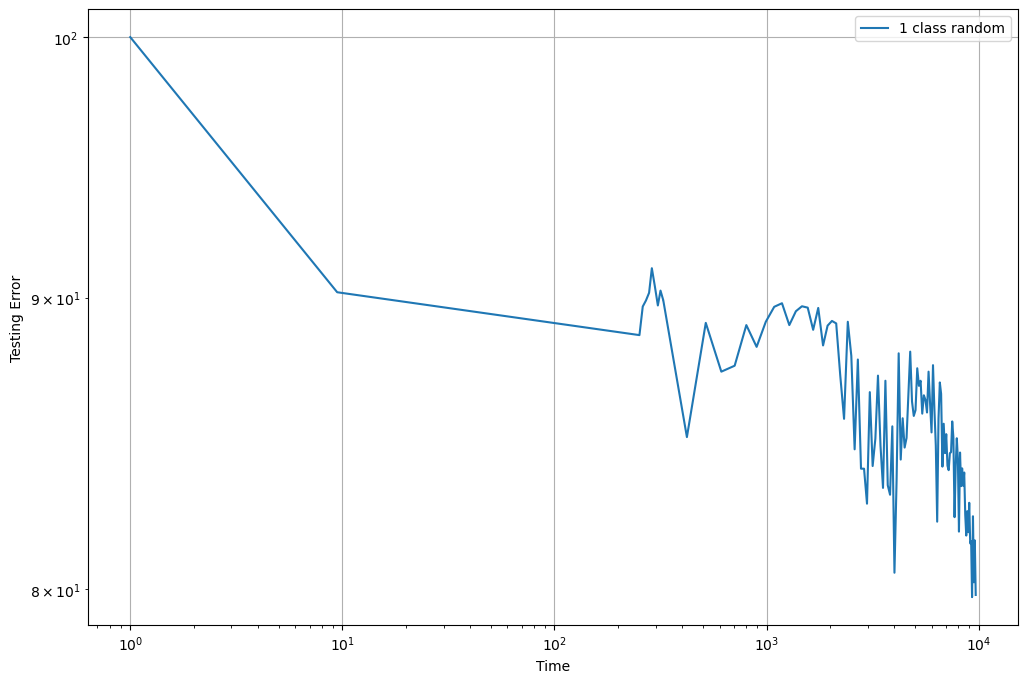

In [84]:
train_acc3 = []
val_acc3 = []
times3 = []
train_acc3.append(100.0)
val_acc3.append(100.0)
times3.append(1.0)
for metrics in server3.log["performance_metrics"]:
    train_acc3.append(100-metrics["train_acc"]*100)
    val_acc3.append(100-metrics["val_acc"]*100)
    times3.append(metrics["time"])
    
plt.figure(figsize=(12,8))
plt.xscale("log")
plt.yscale("log")

plt.plot(times3, val_acc3, label="1 class random")
plt.grid(visible=True)
plt.xlabel("Time")
plt.ylabel("Testing Error")
plt.legend(loc="upper right")
#plt.savefig("Heterogeneous PVI on MNIST.png")
plt.show()

In [83]:
train_acc = []
val_acc = []
times = []
train_acc.append(100.0)
val_acc.append(100.0)
times.append(1.0)
for metrics in server.log["performance_metrics"]:
    train_acc.append(100-metrics["train_acc"]*100)
    val_acc.append(100-metrics["val_acc"]*100)
    times.append(metrics["time"])
    
train_acc2 = []
val_acc2 = []
times2 = []
train_acc2.append(100.0)
val_acc2.append(100.0)
times2.append(1.0)
for metrics in server2.log["performance_metrics"]:
    train_acc2.append(100-metrics["train_acc"]*100)
    val_acc2.append(100-metrics["val_acc"]*100)
    times2.append(metrics["time"])
    
train_acc3 = []
val_acc3 = []
times3 = []
train_acc3.append(100.0)
val_acc3.append(100.0)
times3.append(1.0)
for metrics in server3.log["performance_metrics"]:
    train_acc3.append(100-metrics["train_acc"]*100)
    val_acc3.append(100-metrics["val_acc"]*100)
    times3.append(metrics["time"])
    
plt.figure(figsize=(12,8))
plt.xscale("log")
plt.yscale("log")
plt.plot(times, val_acc, label="1 class ordered")
plt.plot(times2, val_acc2, label="2 classes per client random")
plt.plot(times3, val_acc3, label="1 class random")
plt.grid(visible=True)
plt.xlabel("Time")
plt.ylabel("Testing Error")
plt.legend(loc="upper right")
plt.savefig("Heterogeneous PVI on MNIST.png")
plt.show()

NameError: name 'server' is not defined